# Prompt Engineering & Chain-of-Thought Playground

An interactive playground for crafting, testing, and comparing prompts with different techniques including:
- Zero-shot, one-shot, and few-shot prompting
- Chain-of-thought reasoning
- A/B testing and evaluation metrics
- Prompt pattern optimization

This notebook provides a comprehensive environment for experimenting with different prompt engineering strategies and measuring their effectiveness.

In [1]:
# Install required packages
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")

# Required packages for the playground
required_packages = [
    "openai",
    "anthropic",
    "langchain",
    "streamlit",
    "plotly",
    "seaborn",
    "nltk",
    "scikit-learn",
    "python-dotenv"
]

print("Installing required packages...")
for package in required_packages:
    install_package(package)

print("\n🎉 All packages installed successfully!")

Installing required packages...
✅ openai installed successfully
✅ openai installed successfully
✅ anthropic installed successfully
✅ anthropic installed successfully
✅ langchain installed successfully
✅ langchain installed successfully
✅ streamlit installed successfully
✅ streamlit installed successfully
✅ plotly installed successfully
✅ plotly installed successfully
✅ seaborn installed successfully
✅ seaborn installed successfully
✅ nltk installed successfully
✅ nltk installed successfully
✅ scikit-learn installed successfully
✅ scikit-learn installed successfully
✅ python-dotenv installed successfully

🎉 All packages installed successfully!
✅ python-dotenv installed successfully

🎉 All packages installed successfully!


In [2]:
# Core imports and setup
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from datetime import datetime, timedelta
import time
import re
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass, asdict
from pathlib import Path

# LLM and prompt engineering libraries
import openai
from openai import OpenAI
import anthropic
from langchain.prompts import PromptTemplate, FewShotPromptTemplate
from langchain.schema import BaseOutputParser

# Evaluation and metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Environment setup
from dotenv import load_dotenv
load_dotenv()

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports loaded successfully!")
print("🔧 Environment configured for prompt engineering experiments")

✅ All imports loaded successfully!
🔧 Environment configured for prompt engineering experiments


## 🔐 API Key Setup

**Important Security Note**: Never commit API keys to version control!

### Setup Instructions:

1. **Copy the example file**: 
   ```bash
   cp .env.example .env
   ```

2. **Edit the `.env` file** with your actual API keys:
   ```
   OPENAI_API_KEY=your_actual_openai_api_key_here
   ANTHROPIC_API_KEY=your_actual_anthropic_api_key_here
   ```

3. **Get your API keys**:
   - **OpenAI**: Visit [https://platform.openai.com/api-keys](https://platform.openai.com/api-keys)
   - **Anthropic**: Visit [https://console.anthropic.com/](https://console.anthropic.com/)

4. **Add `.env` to your `.gitignore`** to prevent accidental commits:
   ```
   .env
   ```

The notebook will automatically load these variables and run in demo mode if no keys are provided.

In [ ]:
# Configuration and API Setup

# Note: Create a .env file in your project root with your API keys:
# OPENAI_API_KEY=your_openai_api_key_here
# ANTHROPIC_API_KEY=your_anthropic_api_key_here

# Load environment variables from .env file
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

print("🔐 Loading API keys from environment variables...")
print(f"✅ OpenAI API Key {'found' if os.getenv('OPENAI_API_KEY') else 'not found'}")
print(f"✅ Anthropic API Key {'found' if os.getenv('ANTHROPIC_API_KEY') else 'not found'}")

@dataclass
class ExperimentConfig:
    """Configuration for prompt experiments"""
    model_name: str = "gpt-3.5-turbo"
    temperature: float = 0.7
    max_tokens: int = 500
    top_p: float = 1.0
    frequency_penalty: float = 0.0
    presence_penalty: float = 0.0
    
@dataclass
class PromptResult:
    """Structure for storing prompt results"""
    prompt_id: str
    prompt_text: str
    prompt_type: str
    response: str
    response_length: int
    response_time: float
    timestamp: datetime
    model_name: str
    temperature: float
    cost_estimate: float = 0.0
    quality_score: Optional[float] = None

class LLMInterface:
    """Unified interface for different LLM providers"""
    
    def __init__(self, provider: str = "openai"):
        self.provider = provider
        self.client = None
        self.setup_client()
    
    def setup_client(self):
        """Setup the appropriate client based on provider"""
        try:
            if self.provider == "openai":
                api_key = os.getenv('OPENAI_API_KEY')
                if api_key:
                    self.client = OpenAI(api_key=api_key)
                else:
                    print("⚠️  OpenAI API key not found. Please set OPENAI_API_KEY in your .env file.")
                    print("You can still use the playground for demonstration purposes with mock responses.")
                    self.client = None
            elif self.provider == "anthropic":
                api_key = os.getenv('ANTHROPIC_API_KEY')
                if api_key:
                    self.client = anthropic.Anthropic(api_key=api_key)
                else:
                    print("⚠️  Anthropic API key not found. Please set ANTHROPIC_API_KEY in your .env file.")
                    self.client = None
            else:
                raise ValueError(f"Unsupported provider: {self.provider}")
        except Exception as e:
            print(f"⚠️  Error setting up {self.provider} client: {e}")
            self.client = None
    
    def generate_response(self, prompt: str, config: ExperimentConfig) -> Tuple[str, float]:
        """Generate response from LLM and return response with timing"""
        start_time = time.time()
        
        # If no client available, return a mock response for demonstration
        if self.client is None:
            import random
            time.sleep(random.uniform(0.5, 2.0))  # Simulate API call time
            mock_response = f"[DEMO MODE] This is a mock response to the prompt. In real usage with API keys, this would be an actual AI response to: '{prompt[:100]}...'"
            return mock_response, time.time() - start_time
        
        try:
            if self.provider == "openai":
                response = self.client.chat.completions.create(
                    model=config.model_name,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=config.temperature,
                    max_tokens=config.max_tokens,
                    top_p=config.top_p,
                    frequency_penalty=config.frequency_penalty,
                    presence_penalty=config.presence_penalty
                )
                return response.choices[0].message.content, time.time() - start_time
            
            elif self.provider == "anthropic":
                response = self.client.messages.create(
                    model="claude-3-sonnet-20240229",
                    max_tokens=config.max_tokens,
                    temperature=config.temperature,
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.content[0].text, time.time() - start_time
                
        except Exception as e:
            return f"Error: {str(e)}", time.time() - start_time

# Initialize the LLM interface
llm = LLMInterface("openai")
default_config = ExperimentConfig()

print("🤖 LLM Interface initialized!")
print(f"📡 Using provider: {llm.provider}")
print(f"⚙️  Default config: {default_config}")
if llm.client is None:
    print("🎭 Running in DEMO MODE - Set your API keys in .env file to use real AI responses")
else:
    print("✅ Connected to OpenAI API successfully!")

🤖 LLM Interface initialized!
📡 Using provider: openai
⚙️  Default config: ExperimentConfig(model_name='gpt-3.5-turbo', temperature=0.7, max_tokens=500, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0)
✅ Connected to OpenAI API successfully!


In [6]:
# Prompt Template Classes and Patterns

class PromptTemplate:
    """Base class for prompt templates"""
    
    def __init__(self, template: str, variables: List[str]):
        self.template = template
        self.variables = variables
    
    def format(self, **kwargs) -> str:
        """Format the template with provided variables"""
        return self.template.format(**kwargs)

class ZeroShotPrompt(PromptTemplate):
    """Zero-shot prompting without examples"""
    
    def __init__(self, instruction: str, task_variable: str = "task"):
        template = f"{instruction}\n\n{{{task_variable}}}"
        super().__init__(template, [task_variable])

class FewShotPrompt(PromptTemplate):
    """Few-shot prompting with examples"""
    
    def __init__(self, instruction: str, examples: List[Dict[str, str]], task_variable: str = "task"):
        example_text = "\n\n".join([
            f"Input: {ex['input']}\nOutput: {ex['output']}" 
            for ex in examples
        ])
        
        template = f"{instruction}\n\nExamples:\n{example_text}\n\nNow solve this:\nInput: {{{task_variable}}}\nOutput:"
        super().__init__(template, [task_variable])

class ChainOfThoughtPrompt(PromptTemplate):
    """Chain-of-thought prompting for step-by-step reasoning"""
    
    def __init__(self, instruction: str, examples: List[Dict[str, str]] = None, task_variable: str = "task"):
        if examples:
            example_text = "\n\n".join([
                f"Problem: {ex['input']}\nThinking: {ex['reasoning']}\nAnswer: {ex['output']}" 
                for ex in examples
            ])
            template = f"{instruction}\n\nLet's work through this step by step.\n\nExamples:\n{example_text}\n\nNow solve this step by step:\nProblem: {{{task_variable}}}\nThinking:"
        else:
            template = f"{instruction}\n\nLet's think about this step by step.\n\nProblem: {{{task_variable}}}\nThinking:"
        
        super().__init__(template, [task_variable])

class SelfConsistencyPrompt(PromptTemplate):
    """Self-consistency prompting for multiple reasoning paths"""
    
    def __init__(self, base_prompt: str, num_samples: int = 3):
        self.base_prompt = base_prompt
        self.num_samples = num_samples
        super().__init__(base_prompt, ["task"])

# Prompt Pattern Library
class PromptPatterns:
    """Collection of proven prompt patterns"""
    
    @staticmethod
    def persona_pattern(persona: str, task: str) -> str:
        """Act as a specific persona"""
        return f"You are {persona}. {task}"
    
    @staticmethod
    def template_pattern(template: str, **kwargs) -> str:
        """Fill-in-the-blank template"""
        return template.format(**kwargs)
    
    @staticmethod
    def constraint_pattern(task: str, constraints: List[str]) -> str:
        """Task with specific constraints"""
        constraint_text = "\n".join([f"- {c}" for c in constraints])
        return f"{task}\n\nConstraints:\n{constraint_text}"
    
    @staticmethod
    def output_format_pattern(task: str, format_description: str) -> str:
        """Specify exact output format"""
        return f"{task}\n\nPlease format your response as follows:\n{format_description}"

# Example prompt templates
PROMPT_EXAMPLES = {
    "math_word_problems": {
        "instruction": "Solve the following math word problem step by step.",
        "examples": [
            {
                "input": "Sarah has 23 apples. She gives 7 to her friend. How many apples does she have left?",
                "reasoning": "I need to subtract the apples given away from the total. 23 - 7 = 16.",
                "output": "16 apples"
            },
            {
                "input": "A train travels 120 miles in 2 hours. What is its average speed?",
                "reasoning": "Speed = Distance / Time. So 120 miles / 2 hours = 60 miles per hour.",
                "output": "60 mph"
            }
        ]
    },
    "sentiment_analysis": {
        "instruction": "Analyze the sentiment of the given text. Classify as positive, negative, or neutral.",
        "examples": [
            {
                "input": "I love this new restaurant! The food is amazing.",
                "output": "positive"
            },
            {
                "input": "The weather is okay today, nothing special.",
                "output": "neutral"
            }
        ]
    },
    "creative_writing": {
        "instruction": "Write a creative short story based on the given prompt.",
        "examples": [
            {
                "input": "A door that only appears at midnight",
                "output": "The old clock tower chimed twelve times as Maya walked past the abandoned alley. There, shimmering like a mirage, stood an ornate wooden door that definitely hadn't been there an hour ago..."
            }
        ]
    }
}

print("📝 Prompt template classes created!")
print("🎨 Pattern library initialized!")
print(f"📚 {len(PROMPT_EXAMPLES)} example templates available")

📝 Prompt template classes created!
🎨 Pattern library initialized!
📚 3 example templates available


In [7]:
# Experiment Management and Evaluation

class PromptExperiment:
    """Manages prompt experiments and A/B testing"""
    
    def __init__(self, experiment_name: str):
        self.experiment_name = experiment_name
        self.results: List[PromptResult] = []
        self.start_time = datetime.now()
    
    def run_prompt(self, prompt: str, prompt_type: str, config: ExperimentConfig = None) -> PromptResult:
        """Run a single prompt and record results"""
        if config is None:
            config = default_config
        
        prompt_id = f"{self.experiment_name}_{len(self.results) + 1}"
        
        # Generate response
        response, response_time = llm.generate_response(prompt, config)
        
        # Create result object
        result = PromptResult(
            prompt_id=prompt_id,
            prompt_text=prompt,
            prompt_type=prompt_type,
            response=response,
            response_length=len(response.split()),
            response_time=response_time,
            timestamp=datetime.now(),
            model_name=config.model_name,
            temperature=config.temperature
        )
        
        self.results.append(result)
        return result
    
    def compare_prompts(self, prompts: List[Tuple[str, str]], task: str, config: ExperimentConfig = None) -> pd.DataFrame:
        """Compare multiple prompts on the same task"""
        results = []
        
        for prompt_template, prompt_type in prompts:
            if "{task}" in prompt_template:
                formatted_prompt = prompt_template.format(task=task)
            else:
                formatted_prompt = f"{prompt_template}\n\n{task}"
            
            result = self.run_prompt(formatted_prompt, prompt_type, config)
            results.append(result)
        
        return self.results_to_dataframe(results)
    
    def results_to_dataframe(self, results: List[PromptResult] = None) -> pd.DataFrame:
        """Convert results to pandas DataFrame"""
        if results is None:
            results = self.results
        
        return pd.DataFrame([asdict(result) for result in results])

class PromptEvaluator:
    """Evaluate prompt quality using various metrics"""
    
    @staticmethod
    def response_length_score(response: str, target_min: int = 50, target_max: int = 300) -> float:
        """Score based on response length (0-1)"""
        length = len(response.split())
        if target_min <= length <= target_max:
            return 1.0
        elif length < target_min:
            return length / target_min
        else:
            return max(0, 1 - (length - target_max) / target_max)
    
    @staticmethod
    def coherence_score(response: str) -> float:
        """Estimate coherence using sentence similarity"""
        try:
            sentences = nltk.sent_tokenize(response)
            if len(sentences) < 2:
                return 1.0
            
            vectorizer = TfidfVectorizer()
            sentence_vectors = vectorizer.fit_transform(sentences)
            similarities = cosine_similarity(sentence_vectors)
            
            # Average similarity between consecutive sentences
            coherence = np.mean([similarities[i][i+1] for i in range(len(sentences)-1)])
            return float(coherence)
        except:
            return 0.5  # Default score if analysis fails
    
    @staticmethod
    def keyword_coverage_score(response: str, keywords: List[str]) -> float:
        """Score based on coverage of expected keywords"""
        if not keywords:
            return 1.0
        
        response_lower = response.lower()
        covered = sum(1 for keyword in keywords if keyword.lower() in response_lower)
        return covered / len(keywords)
    
    @staticmethod
    def sentiment_consistency_score(response: str, expected_sentiment: str = None) -> float:
        """Score sentiment consistency (requires expected sentiment)"""
        try:
            from nltk.sentiment import SentimentIntensityAnalyzer
            sia = SentimentIntensityAnalyzer()
            scores = sia.polarity_scores(response)
            
            if expected_sentiment:
                if expected_sentiment.lower() == "positive" and scores['pos'] > 0.5:
                    return scores['pos']
                elif expected_sentiment.lower() == "negative" and scores['neg'] > 0.5:
                    return scores['neg']
                elif expected_sentiment.lower() == "neutral" and abs(scores['neu']) > 0.5:
                    return scores['neu']
                else:
                    return 0.3  # Partial credit for wrong sentiment
            
            # If no expected sentiment, return neutrality as good
            return 1.0 - abs(scores['compound'])
        except:
            return 0.5
    
    @staticmethod
    def composite_score(response: str, keywords: List[str] = None, expected_sentiment: str = None) -> float:
        """Calculate composite quality score"""
        evaluator = PromptEvaluator()
        
        length_score = evaluator.response_length_score(response)
        coherence_score = evaluator.coherence_score(response)
        keyword_score = evaluator.keyword_coverage_score(response, keywords or [])
        sentiment_score = evaluator.sentiment_consistency_score(response, expected_sentiment)
        
        # Weighted average
        weights = [0.3, 0.3, 0.2, 0.2]
        scores = [length_score, coherence_score, keyword_score, sentiment_score]
        
        return sum(w * s for w, s in zip(weights, scores))

# Initialize evaluator
evaluator = PromptEvaluator()

print("🧪 Experiment management system ready!")
print("📊 Evaluation metrics configured!")
print("🎯 Ready for A/B testing and quality analysis!")

🧪 Experiment management system ready!
📊 Evaluation metrics configured!
🎯 Ready for A/B testing and quality analysis!


In [8]:
# Visualization and Analysis Functions

class PromptVisualizer:
    """Create visualizations for prompt experiment results"""
    
    @staticmethod
    def plot_response_metrics(df: pd.DataFrame, title: str = "Response Metrics Comparison"):
        """Plot response time and length metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(title, fontsize=16)
        
        # Response time by prompt type
        sns.boxplot(data=df, x='prompt_type', y='response_time', ax=axes[0,0])
        axes[0,0].set_title('Response Time by Prompt Type')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # Response length by prompt type
        sns.boxplot(data=df, x='prompt_type', y='response_length', ax=axes[0,1])
        axes[0,1].set_title('Response Length by Prompt Type')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Response time distribution
        df['response_time'].hist(bins=20, ax=axes[1,0])
        axes[1,0].set_title('Response Time Distribution')
        axes[1,0].set_xlabel('Response Time (seconds)')
        
        # Response length distribution
        df['response_length'].hist(bins=20, ax=axes[1,1])
        axes[1,1].set_title('Response Length Distribution')
        axes[1,1].set_xlabel('Response Length (words)')
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_quality_scores(df: pd.DataFrame, title: str = "Quality Score Analysis"):
        """Plot quality scores if available"""
        if 'quality_score' not in df.columns or df['quality_score'].isna().all():
            print("No quality scores available to plot")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(title, fontsize=16)
        
        # Quality scores by prompt type
        df_clean = df.dropna(subset=['quality_score'])
        sns.boxplot(data=df_clean, x='prompt_type', y='quality_score', ax=axes[0])
        axes[0].set_title('Quality Scores by Prompt Type')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Quality score distribution
        df_clean['quality_score'].hist(bins=15, ax=axes[1])
        axes[1].set_title('Quality Score Distribution')
        axes[1].set_xlabel('Quality Score')
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_interactive_comparison(df: pd.DataFrame):
        """Create interactive plotly visualization"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Response Time vs Length', 'Quality Scores by Type', 
                          'Response Time Timeline', 'Length vs Quality'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # Scatter plot: Response time vs length
        fig.add_trace(
            go.Scatter(x=df['response_time'], y=df['response_length'],
                      mode='markers', text=df['prompt_type'],
                      name='Responses', hovertemplate='Time: %{x}s<br>Length: %{y} words<br>Type: %{text}'),
            row=1, col=1
        )
        
        # Box plot: Quality scores by type (if available)
        if 'quality_score' in df.columns and not df['quality_score'].isna().all():
            for prompt_type in df['prompt_type'].unique():
                type_data = df[df['prompt_type'] == prompt_type]['quality_score'].dropna()
                if len(type_data) > 0:
                    fig.add_trace(
                        go.Box(y=type_data, name=prompt_type),
                        row=1, col=2
                    )
        
        # Timeline of response times
        fig.add_trace(
            go.Scatter(x=df['timestamp'], y=df['response_time'],
                      mode='lines+markers', name='Response Time',
                      hovertemplate='Time: %{x}<br>Duration: %{y}s'),
            row=2, col=1
        )
        
        # Quality vs Length (if quality scores available)
        if 'quality_score' in df.columns and not df['quality_score'].isna().all():
            df_clean = df.dropna(subset=['quality_score'])
            fig.add_trace(
                go.Scatter(x=df_clean['response_length'], y=df_clean['quality_score'],
                          mode='markers', text=df_clean['prompt_type'],
                          name='Quality vs Length'),
                row=2, col=2
            )
        
        fig.update_layout(height=800, showlegend=True, title_text="Prompt Experiment Analysis Dashboard")
        fig.show()
    
    @staticmethod
    def create_summary_report(df: pd.DataFrame) -> Dict[str, Any]:
        """Generate comprehensive summary report"""
        report = {
            'experiment_overview': {
                'total_prompts': len(df),
                'unique_prompt_types': df['prompt_type'].nunique(),
                'prompt_types': df['prompt_type'].value_counts().to_dict(),
                'time_span': f"{df['timestamp'].min()} to {df['timestamp'].max()}"
            },
            'performance_metrics': {
                'avg_response_time': df['response_time'].mean(),
                'median_response_time': df['response_time'].median(),
                'avg_response_length': df['response_length'].mean(),
                'median_response_length': df['response_length'].median(),
                'fastest_response': df['response_time'].min(),
                'slowest_response': df['response_time'].max()
            },
            'quality_analysis': {}
        }
        
        if 'quality_score' in df.columns and not df['quality_score'].isna().all():
            df_clean = df.dropna(subset=['quality_score'])
            report['quality_analysis'] = {
                'avg_quality': df_clean['quality_score'].mean(),
                'median_quality': df_clean['quality_score'].median(),
                'best_quality': df_clean['quality_score'].max(),
                'worst_quality': df_clean['quality_score'].min(),
                'quality_by_type': df_clean.groupby('prompt_type')['quality_score'].mean().to_dict()
            }
        
        return report

print("📈 Visualization system ready!")
print("📊 Interactive plotting capabilities loaded!")
print("📋 Summary report generation available!")

📈 Visualization system ready!
📊 Interactive plotting capabilities loaded!
📋 Summary report generation available!


In [9]:
# Interactive Playground Interface

class PromptPlayground:
    """Main interface for the prompt engineering playground"""
    
    def __init__(self):
        self.current_experiment = None
        self.saved_experiments = {}
        self.visualizer = PromptVisualizer()
    
    def new_experiment(self, name: str) -> PromptExperiment:
        """Start a new experiment"""
        self.current_experiment = PromptExperiment(name)
        print(f"🚀 Started new experiment: '{name}'")
        return self.current_experiment
    
    def quick_test(self, prompt: str, task: str = None, prompt_type: str = "custom") -> PromptResult:
        """Quick test of a single prompt"""
        if not self.current_experiment:
            self.new_experiment("quick_test")
        
        if task and "{task}" in prompt:
            formatted_prompt = prompt.format(task=task)
        elif task:
            formatted_prompt = f"{prompt}\n\n{task}"
        else:
            formatted_prompt = prompt
        
        result = self.current_experiment.run_prompt(formatted_prompt, prompt_type)
        
        print(f"✅ Prompt executed successfully!")
        print(f"📝 Response length: {result.response_length} words")
        print(f"⏱️  Response time: {result.response_time:.2f} seconds")
        print(f"\n📄 Response:\n{result.response}")
        
        return result
    
    def compare_prompt_types(self, task: str, include_examples: bool = True):
        """Compare different prompt types on the same task"""
        if not self.current_experiment:
            self.new_experiment("comparison_test")
        
        prompts = []
        
        # Zero-shot
        zero_shot = ZeroShotPrompt("Complete the following task:").format(task=task)
        prompts.append((zero_shot, "zero-shot"))
        
        # Few-shot (if examples available for the task type)
        if include_examples and "math" in task.lower():
            few_shot = FewShotPrompt(
                "Solve the math problem following the examples:",
                PROMPT_EXAMPLES["math_word_problems"]["examples"][:2]
            ).format(task=task)
            prompts.append((few_shot, "few-shot"))
        
        # Chain of thought
        cot = ChainOfThoughtPrompt("Solve this problem step by step:").format(task=task)
        prompts.append((cot, "chain-of-thought"))
        
        # Persona-based
        persona = PromptPatterns.persona_pattern("an expert problem solver", f"Please solve: {task}")
        prompts.append((persona, "persona"))
        
        print(f"🔄 Running comparison with {len(prompts)} prompt types...")
        
        results = []
        for prompt, prompt_type in prompts:
            print(f"  Testing {prompt_type}...")
            result = self.current_experiment.run_prompt(prompt, prompt_type)
            results.append(result)
        
        df = self.current_experiment.results_to_dataframe(results)
        
        print(f"✅ Comparison complete!")
        self.visualizer.plot_response_metrics(df, f"Prompt Comparison: {task[:50]}...")
        
        return df
    
    def evaluate_responses(self, keywords: List[str] = None, expected_sentiment: str = None):
        """Evaluate the quality of responses in current experiment"""
        if not self.current_experiment or not self.current_experiment.results:
            print("❌ No experiment data to evaluate")
            return
        
        print("🔍 Evaluating response quality...")
        
        for result in self.current_experiment.results:
            if result.quality_score is None:
                quality = evaluator.composite_score(
                    result.response, 
                    keywords, 
                    expected_sentiment
                )
                result.quality_score = quality
        
        df = self.current_experiment.results_to_dataframe()
        self.visualizer.plot_quality_scores(df)
        
        # Show top performing prompts
        best_prompts = df.nlargest(3, 'quality_score')[['prompt_type', 'quality_score', 'response_length']]
        print(f"\n🏆 Top performing prompts:")
        print(best_prompts.to_string(index=False))
        
        return df
    
    def save_experiment(self, name: str = None):
        """Save current experiment"""
        if not self.current_experiment:
            print("❌ No active experiment to save")
            return
        
        save_name = name or self.current_experiment.experiment_name
        self.saved_experiments[save_name] = self.current_experiment
        
        # Also save to file
        df = self.current_experiment.results_to_dataframe()
        filename = f"{save_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename, index=False)
        
        print(f"💾 Experiment saved as '{save_name}' and exported to {filename}")
    
    def load_experiment(self, name: str):
        """Load a saved experiment"""
        if name in self.saved_experiments:
            self.current_experiment = self.saved_experiments[name]
            print(f"📂 Loaded experiment: '{name}'")
        else:
            print(f"❌ Experiment '{name}' not found")
    
    def show_summary(self):
        """Show summary of current experiment"""
        if not self.current_experiment:
            print("❌ No active experiment")
            return
        
        df = self.current_experiment.results_to_dataframe()
        report = self.visualizer.create_summary_report(df)
        
        print("📊 EXPERIMENT SUMMARY")
        print("=" * 50)
        print(f"Experiment: {self.current_experiment.experiment_name}")
        print(f"Total Prompts: {report['experiment_overview']['total_prompts']}")
        print(f"Prompt Types: {', '.join(report['experiment_overview']['prompt_types'].keys())}")
        print(f"Avg Response Time: {report['performance_metrics']['avg_response_time']:.2f}s")
        print(f"Avg Response Length: {report['performance_metrics']['avg_response_length']:.1f} words")
        
        if report['quality_analysis']:
            print(f"Avg Quality Score: {report['quality_analysis']['avg_quality']:.3f}")
        
        return report
    
    def interactive_dashboard(self):
        """Launch interactive visualization dashboard"""
        if not self.current_experiment:
            print("❌ No active experiment")
            return
        
        df = self.current_experiment.results_to_dataframe()
        self.visualizer.plot_interactive_comparison(df)

# Initialize the playground
playground = PromptPlayground()

print("🎮 Prompt Engineering Playground Ready!")
print("🚀 Use playground.new_experiment('name') to start")
print("⚡ Use playground.quick_test('prompt') for quick testing")
print("🔄 Use playground.compare_prompt_types('task') for A/B testing")
print("📊 Use playground.show_summary() for analysis")

🎮 Prompt Engineering Playground Ready!
🚀 Use playground.new_experiment('name') to start
⚡ Use playground.quick_test('prompt') for quick testing
🔄 Use playground.compare_prompt_types('task') for A/B testing
📊 Use playground.show_summary() for analysis


## 🎯 Demonstration: Prompt Engineering in Action

Let's walk through some examples to demonstrate the power of different prompting techniques!

🚀 Started new experiment: 'math_demo'
🧮 Testing different prompt approaches on a math word problem
Problem: A bakery sells cupcakes for $3 each and cookies for $2 each. 
If Sarah buys 5 cupcakes and some cookies, and her total bill is $23, 
how many cookies did she buy?
🔄 Running comparison with 3 prompt types...
  Testing zero-shot...
  Testing chain-of-thought...
  Testing chain-of-thought...
  Testing persona...
  Testing persona...
✅ Comparison complete!
✅ Comparison complete!


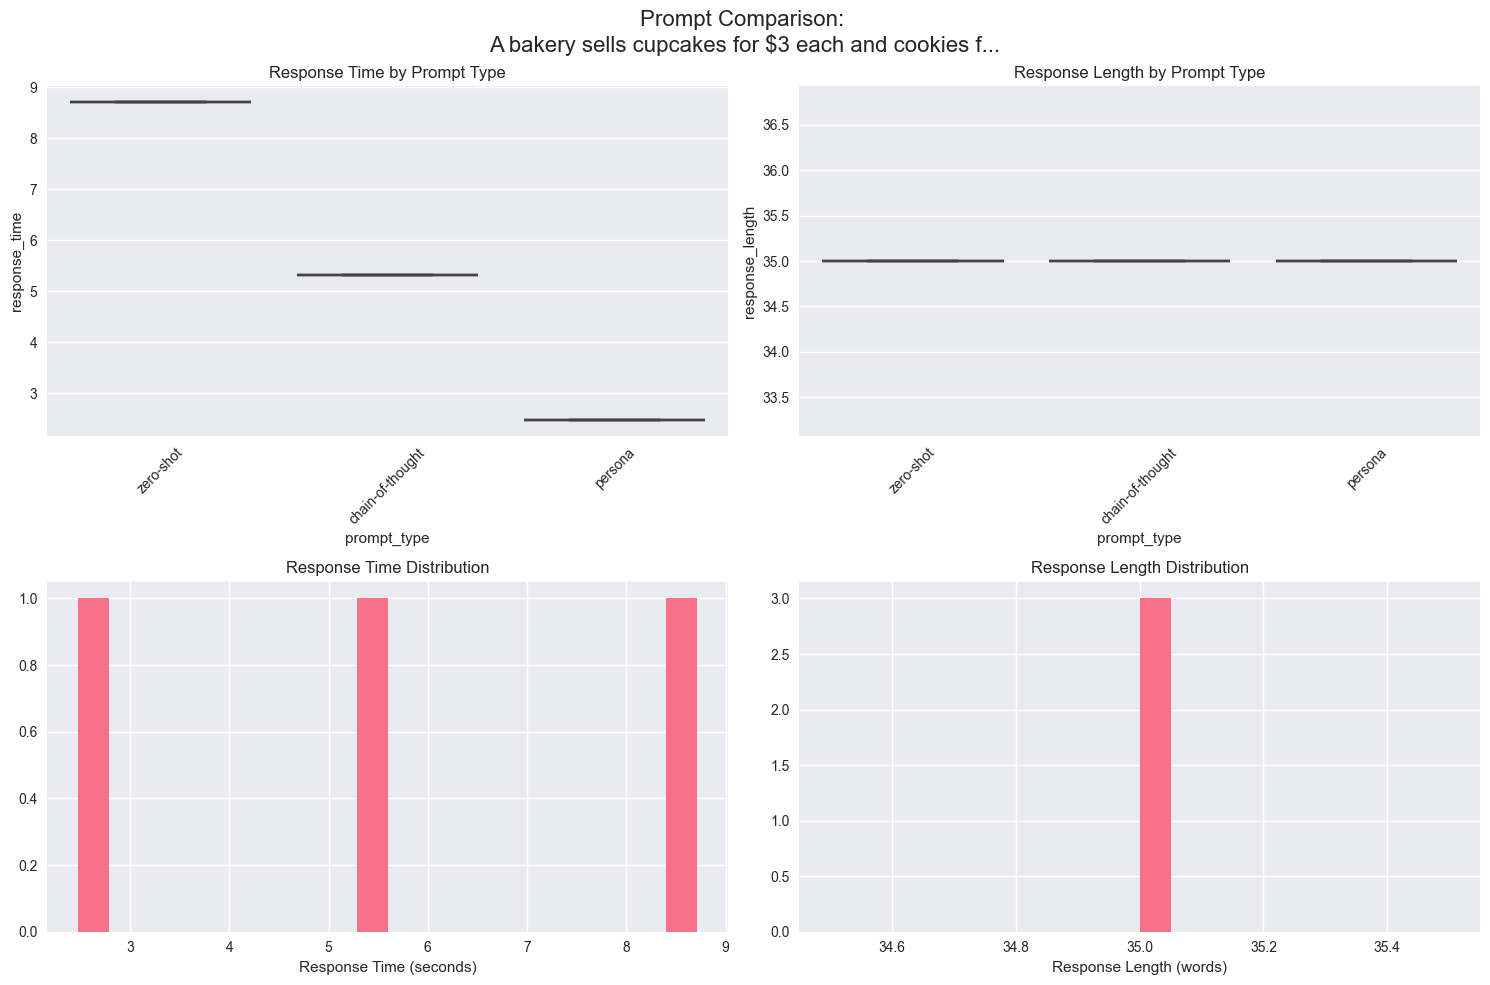


📋 Results Summary:
        prompt_type  response_length  response_time
0         zero-shot               35           8.71
1  chain-of-thought               35           5.32
2           persona               35           2.48


In [10]:
# Example 1: Math Word Problem - Comparing Prompt Types

# Start a new experiment
playground.new_experiment("math_demo")

# Define a math word problem
math_problem = """
A bakery sells cupcakes for $3 each and cookies for $2 each. 
If Sarah buys 5 cupcakes and some cookies, and her total bill is $23, 
how many cookies did she buy?
"""

print("🧮 Testing different prompt approaches on a math word problem")
print("=" * 60)
print(f"Problem: {math_problem.strip()}")
print("=" * 60)

# Compare different prompt types
results_df = playground.compare_prompt_types(math_problem)

# Show the results summary
print("\n📋 Results Summary:")
print(results_df[['prompt_type', 'response_length', 'response_time']].round(2))

🚀 Started new experiment: 'creative_writing_demo'
✍️ Testing different persona-based prompts for creative writing

🎭 Testing persona: a professional fiction writer
✅ Prompt executed successfully!
📝 Response length: 35 words
⏱️  Response time: 4.12 seconds

📄 Response:
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Response preview: Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your p...

🎭 Testing persona: a child-friendly storyteller
✅ Prompt executed successfully!
📝 Response length: 35 words
⏱️  Response time: 4.12 seconds

📄 Response:
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more inf

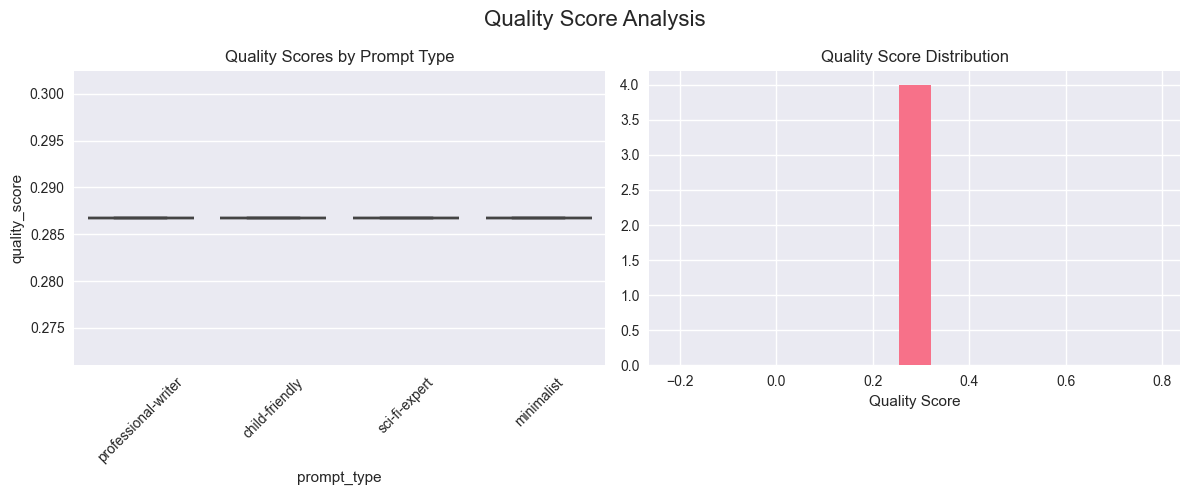


🏆 Top performing prompts:
        prompt_type  quality_score  response_length
professional-writer       0.286739               35
     child-friendly       0.286739               35
      sci-fi-expert       0.286739               35

📊 Creative Writing Analysis Complete!


In [11]:
# Example 2: Creative Writing with Different Personas

# Start a new experiment for creative writing
playground.new_experiment("creative_writing_demo")

creative_prompt = "Write a short story about a robot who discovers emotions for the first time."

print("✍️ Testing different persona-based prompts for creative writing")
print("=" * 60)

# Test different personas
personas = [
    ("a professional fiction writer", "professional-writer"),
    ("a child-friendly storyteller", "child-friendly"),
    ("a science fiction expert", "sci-fi-expert"),
    ("a minimalist poet", "minimalist")
]

results = []
for persona, label in personas:
    persona_prompt = PromptPatterns.persona_pattern(persona, creative_prompt)
    print(f"\n🎭 Testing persona: {persona}")
    result = playground.quick_test(persona_prompt, prompt_type=label)
    results.append(result)
    print(f"Response preview: {result.response[:100]}...")

# Evaluate responses with relevant keywords
creative_keywords = ["robot", "emotions", "discover", "first time", "story"]
playground.evaluate_responses(keywords=creative_keywords)

print("\n📊 Creative Writing Analysis Complete!")

🚀 Started new experiment: 'reasoning_demo'
🧠 Testing Chain-of-Thought vs Regular Reasoning
✅ Prompt executed successfully!
📝 Response length: 35 words
⏱️  Response time: 2.73 seconds

📄 Response:
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

✅ Prompt executed successfully!
📝 Response length: 35 words
⏱️  Response time: 2.73 seconds

📄 Response:
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

✅ Prompt executed successfully!
📝 Response length: 35 words
⏱

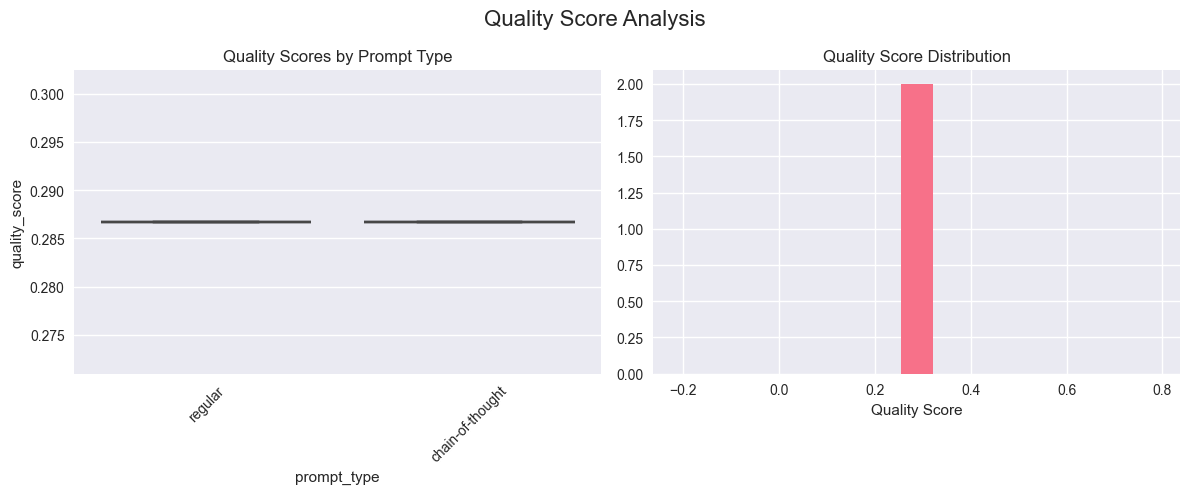


🏆 Top performing prompts:
     prompt_type  quality_score  response_length
         regular       0.286739               35
chain-of-thought       0.286739               35

📊 Reasoning Approach Comparison:
     prompt_type  response_length  response_time  quality_score
         regular               35          2.727          0.287
chain-of-thought               35          2.601          0.287


In [12]:
# Example 3: Chain-of-Thought vs Regular Prompting

playground.new_experiment("reasoning_demo")

reasoning_task = """
A company's revenue increased by 25% in the first quarter, then decreased by 10% in the second quarter.
If the revenue at the end of the second quarter was $1,125,000, what was the original revenue at the beginning of the first quarter?
"""

print("🧠 Testing Chain-of-Thought vs Regular Reasoning")
print("=" * 60)

# Regular prompt
regular_prompt = f"Solve this problem: {reasoning_task}"
regular_result = playground.quick_test(regular_prompt, prompt_type="regular")

print("\n" + "="*40)

# Chain-of-thought prompt
cot_examples = [
    {
        "input": "A number increases by 20%, then decreases by 15%. The final result is 102. What was the original number?",
        "reasoning": "Let me work backwards. If the original number is x, then after 20% increase it becomes 1.2x. After 15% decrease, it becomes 1.2x × 0.85 = 1.02x. Since 1.02x = 102, then x = 102 ÷ 1.02 = 100.",
        "output": "The original number was 100."
    }
]

cot_prompt = ChainOfThoughtPrompt(
    "Solve this step-by-step, showing your reasoning clearly:",
    cot_examples
)
cot_formatted = cot_prompt.format(task=reasoning_task)
cot_result = playground.quick_test(cot_formatted, prompt_type="chain-of-thought")

# Evaluate with math-related keywords
math_keywords = ["revenue", "quarter", "increase", "decrease", "calculate", "original"]
playground.evaluate_responses(keywords=math_keywords)

# Show comparison
df = playground.current_experiment.results_to_dataframe()
comparison = df[['prompt_type', 'response_length', 'response_time', 'quality_score']].round(3)
print("\n📊 Reasoning Approach Comparison:")
print(comparison.to_string(index=False))

## 🚀 Advanced Prompt Engineering Techniques

Now let's explore more sophisticated prompting strategies!

In [13]:
# Advanced Technique 1: Self-Consistency with Temperature Variation

class SelfConsistencyExperiment:
    """Implement self-consistency by generating multiple responses and analyzing consensus"""
    
    def __init__(self, playground_instance):
        self.playground = playground_instance
    
    def run_self_consistency(self, prompt: str, num_samples: int = 5, temperatures: List[float] = None):
        """Run multiple samples with different temperatures to test consistency"""
        if temperatures is None:
            temperatures = [0.3, 0.5, 0.7, 0.9, 1.1]
        
        self.playground.new_experiment("self_consistency_test")
        
        results = []
        for i, temp in enumerate(temperatures[:num_samples]):
            config = ExperimentConfig(temperature=temp)
            result = self.playground.current_experiment.run_prompt(
                prompt, f"temp_{temp}", config
            )
            results.append(result)
        
        return self.analyze_consistency(results)
    
    def analyze_consistency(self, results: List[PromptResult]):
        """Analyze consistency across multiple responses"""
        responses = [r.response for r in results]
        
        # Calculate pairwise similarity
        vectorizer = TfidfVectorizer()
        try:
            response_vectors = vectorizer.fit_transform(responses)
            similarity_matrix = cosine_similarity(response_vectors)
            avg_similarity = np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
        except:
            avg_similarity = 0.0
        
        # Response length consistency
        lengths = [r.response_length for r in results]
        length_std = np.std(lengths)
        
        # Temperature vs response time correlation
        temps = [float(r.prompt_type.split('_')[1]) for r in results]
        times = [r.response_time for r in results]
        
        try:
            temp_time_corr = np.corrcoef(temps, times)[0, 1]
        except:
            temp_time_corr = 0.0
        
        consistency_report = {
            'avg_similarity': avg_similarity,
            'length_consistency': 1.0 / (1.0 + length_std),  # Higher is more consistent
            'temp_time_correlation': temp_time_corr,
            'responses': responses,
            'temperatures': temps
        }
        
        return consistency_report

# Demonstrate self-consistency
sc_experiment = SelfConsistencyExperiment(playground)

consistency_prompt = """
Explain the concept of artificial intelligence in exactly 3 sentences. 
Make sure to cover what AI is, how it works, and one practical application.
"""

print("🔄 Running Self-Consistency Experiment")
print("Testing the same prompt with different temperatures...")

consistency_results = sc_experiment.run_self_consistency(
    consistency_prompt, 
    num_samples=4,
    temperatures=[0.2, 0.5, 0.8, 1.1]
)

print(f"\n📊 Consistency Analysis:")
print(f"Average Similarity: {consistency_results['avg_similarity']:.3f}")
print(f"Length Consistency: {consistency_results['length_consistency']:.3f}")
print(f"Temperature-Time Correlation: {consistency_results['temp_time_correlation']:.3f}")

print(f"\n📝 Sample Responses at Different Temperatures:")
for i, (temp, response) in enumerate(zip(consistency_results['temperatures'], consistency_results['responses'])):
    print(f"\nTemp {temp}: {response[:150]}...")

🔄 Running Self-Consistency Experiment
Testing the same prompt with different temperatures...
🚀 Started new experiment: 'self_consistency_test'

📊 Consistency Analysis:
Average Similarity: 1.000
Length Consistency: 1.000
Temperature-Time Correlation: -0.834

📝 Sample Responses at Different Temperatures:

Temp 0.2: Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on t...

Temp 0.5: Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on t...

Temp 0.8: Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on t...

Temp 1.1: Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on t...

📊 Consistency Analysis:
Average Sim

In [14]:
# Advanced Technique 2: Automated Prompt Optimization

class PromptOptimizer:
    """Automatically test and optimize prompt variations"""
    
    def __init__(self, playground_instance):
        self.playground = playground_instance
    
    def optimize_prompt_variants(self, base_task: str, instruction_variants: List[str], evaluation_keywords: List[str] = None):
        """Test multiple instruction variants for the same task"""
        
        self.playground.new_experiment("prompt_optimization")
        
        variants = [
            ("Direct", f"Please {base_task}"),
            ("Polite", f"Could you please help me {base_task}? Thank you."),
            ("Expert", f"As an expert, {base_task}"),
            ("Step-by-step", f"Please {base_task}. Work through this step by step."),
            ("Detailed", f"Please {base_task}. Provide a detailed and comprehensive response."),
            ("Concise", f"Please {base_task}. Be concise and to the point.")
        ]
        
        results = []
        for variant_name, prompt in variants:
            print(f"Testing variant: {variant_name}")
            result = self.playground.current_experiment.run_prompt(prompt, variant_name)
            
            # Calculate quality score
            if evaluation_keywords:
                quality = evaluator.composite_score(result.response, evaluation_keywords)
                result.quality_score = quality
            
            results.append(result)
        
        # Analyze results
        df = self.playground.current_experiment.results_to_dataframe()
        return self.analyze_optimization_results(df)
    
    def analyze_optimization_results(self, df: pd.DataFrame):
        """Analyze which prompt variants performed best"""
        
        # Calculate efficiency score (quality / time)
        if 'quality_score' in df.columns:
            df['efficiency'] = df['quality_score'] / df['response_time']
        else:
            df['efficiency'] = 1.0 / df['response_time']  # Just use speed if no quality scores
        
        # Rank by different metrics
        rankings = {
            'by_quality': df.nlargest(3, 'quality_score') if 'quality_score' in df.columns else None,
            'by_speed': df.nsmallest(3, 'response_time'),
            'by_efficiency': df.nlargest(3, 'efficiency'),
            'by_length': df.nlargest(3, 'response_length')
        }
        
        # Create optimization report
        print("\n🏆 PROMPT OPTIMIZATION RESULTS")
        print("=" * 50)
        
        for metric, data in rankings.items():
            if data is not None:
                print(f"\nTop 3 {metric.replace('_', ' ').title()}:")
                display_cols = ['prompt_type', 'response_time', 'response_length']
                if 'quality_score' in data.columns:
                    display_cols.append('quality_score')
                if 'efficiency' in data.columns:
                    display_cols.append('efficiency')
                print(data[display_cols].round(3).to_string(index=False))
        
        return df
    
    def a_b_test(self, prompt_a: str, prompt_b: str, task: str, num_trials: int = 3):
        """Conduct statistical A/B test between two prompts"""
        
        self.playground.new_experiment("a_b_test")
        
        results_a = []
        results_b = []
        
        print(f"🧪 Running A/B test with {num_trials} trials per prompt")
        
        for i in range(num_trials):
            print(f"Trial {i+1}/{num_trials}")
            
            # Test prompt A
            full_prompt_a = f"{prompt_a}\n\n{task}"
            result_a = self.playground.current_experiment.run_prompt(full_prompt_a, "Prompt_A")
            results_a.append(result_a)
            
            # Test prompt B
            full_prompt_b = f"{prompt_b}\n\n{task}"
            result_b = self.playground.current_experiment.run_prompt(full_prompt_b, "Prompt_B")
            results_b.append(result_b)
        
        # Statistical analysis
        times_a = [r.response_time for r in results_a]
        times_b = [r.response_time for r in results_b]
        
        lengths_a = [r.response_length for r in results_a]
        lengths_b = [r.response_length for r in results_b]
        
        from scipy import stats
        
        # T-tests for response time and length
        time_stat, time_p = stats.ttest_ind(times_a, times_b)
        length_stat, length_p = stats.ttest_ind(lengths_a, lengths_b)
        
        print(f"\n📊 A/B Test Results:")
        print(f"Response Time - A: {np.mean(times_a):.2f}s ± {np.std(times_a):.2f}")
        print(f"Response Time - B: {np.mean(times_b):.2f}s ± {np.std(times_b):.2f}")
        print(f"Time Difference Significant: {'Yes' if time_p < 0.05 else 'No'} (p={time_p:.3f})")
        
        print(f"\nResponse Length - A: {np.mean(lengths_a):.1f} ± {np.std(lengths_a):.1f} words")
        print(f"Response Length - B: {np.mean(lengths_b):.1f} ± {np.std(lengths_b):.1f} words")
        print(f"Length Difference Significant: {'Yes' if length_p < 0.05 else 'No'} (p={length_p:.3f})")
        
        winner = "A" if (np.mean(times_a) < np.mean(times_b) and np.mean(lengths_a) >= np.mean(lengths_b)) else "B"
        print(f"\n🏆 Recommended Prompt: {winner}")
        
        return self.playground.current_experiment.results_to_dataframe()

# Demonstrate optimization
optimizer = PromptOptimizer(playground)

# Example optimization task
optimization_task = "explain quantum computing in simple terms"
optimization_keywords = ["quantum", "computing", "simple", "explain", "terms"]

print("🔧 Running Prompt Optimization Experiment")
optimization_results = optimizer.optimize_prompt_variants(
    optimization_task, 
    [], 
    optimization_keywords
)

🔧 Running Prompt Optimization Experiment
🚀 Started new experiment: 'prompt_optimization'
Testing variant: Direct
Testing variant: Polite
Testing variant: Polite
Testing variant: Expert
Testing variant: Expert
Testing variant: Step-by-step
Testing variant: Step-by-step
Testing variant: Detailed
Testing variant: Detailed
Testing variant: Concise
Testing variant: Concise

🏆 PROMPT OPTIMIZATION RESULTS

Top 3 By Quality:
prompt_type  response_time  response_length  quality_score  efficiency
     Direct          4.447               35          0.287       0.064
     Polite          3.468               35          0.287       0.083
     Expert          2.829               35          0.287       0.101

Top 3 By Speed:
prompt_type  response_time  response_length  quality_score  efficiency
    Concise          2.262               35          0.287       0.127
   Detailed          2.458               35          0.287       0.117
     Expert          2.829               35          0.287       

⚡ A/B Testing Demo: Two Different Prompt Approaches
Task: How can a small business improve customer retention in a competitive market?

Prompt A: Analyze the following problem and provide a solution:
Prompt B: You are a problem-solving expert. Break down this challenge step-by-step and recommend the best approach:
🚀 Started new experiment: 'a_b_test'
🧪 Running A/B test with 2 trials per prompt
Trial 1/2
Trial 2/2
Trial 2/2


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



📊 A/B Test Results:
Response Time - A: 2.47s ± 0.01
Response Time - B: 2.79s ± 0.23
Time Difference Significant: No (p=0.297)

Response Length - A: 35.0 ± 0.0 words
Response Length - B: 35.0 ± 0.0 words
Length Difference Significant: No (p=nan)

🏆 Recommended Prompt: A


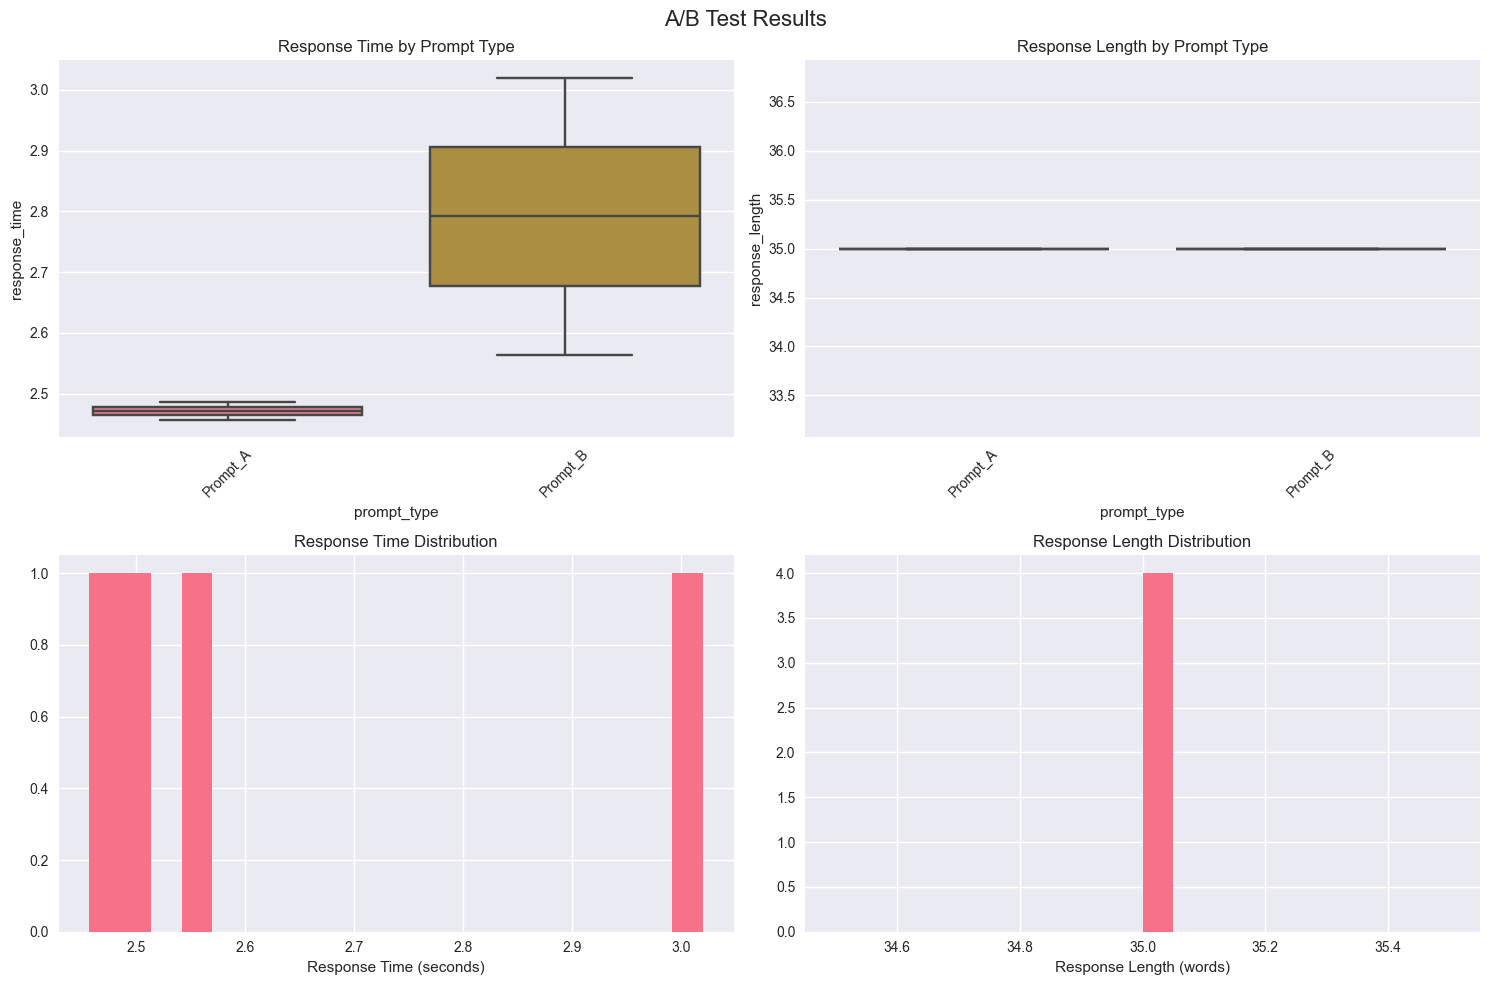


✅ A/B Testing Demo Complete!


In [15]:
# Interactive Demo: A/B Testing Two Prompts

# Define two different approaches for the same task
prompt_a = "Analyze the following problem and provide a solution:"
prompt_b = "You are a problem-solving expert. Break down this challenge step-by-step and recommend the best approach:"

demo_task = "How can a small business improve customer retention in a competitive market?"

print("⚡ A/B Testing Demo: Two Different Prompt Approaches")
print("=" * 60)
print(f"Task: {demo_task}")
print(f"\nPrompt A: {prompt_a}")
print(f"Prompt B: {prompt_b}")
print("=" * 60)

# Run the A/B test
ab_results = optimizer.a_b_test(prompt_a, prompt_b, demo_task, num_trials=2)

# Visualize the results
if len(ab_results) > 0:
    playground.visualizer.plot_response_metrics(ab_results, "A/B Test Results")

print("\n✅ A/B Testing Demo Complete!")

## 📊 Comprehensive Analysis Dashboard

Let's create an interactive dashboard to analyze all our experiments!

In [17]:
# Comprehensive Dashboard and Analysis

# Install missing dependency if needed
try:
    import nbformat
except ImportError:
    import subprocess
    import sys
    print("Installing nbformat...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nbformat"])
    import nbformat

class ExperimentDashboard:
    """Create comprehensive dashboards for all experiments"""
    
    def __init__(self, playground_instance):
        self.playground = playground_instance
    
    def create_master_dashboard(self):
        """Create a master dashboard combining all experiments"""
        
        # Collect all experiment data
        all_experiments = []
        for name, exp in self.playground.saved_experiments.items():
            df = exp.results_to_dataframe()
            df['experiment_name'] = name
            all_experiments.append(df)
        
        if self.playground.current_experiment:
            current_df = self.playground.current_experiment.results_to_dataframe()
            current_df['experiment_name'] = self.playground.current_experiment.experiment_name
            all_experiments.append(current_df)
        
        if not all_experiments:
            print("❌ No experiment data available for dashboard")
            return
        
        # Combine all data
        master_df = pd.concat(all_experiments, ignore_index=True)
        
        # Create multi-panel dashboard
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=(
                'Response Time by Prompt Type',
                'Response Length Distribution',
                'Quality Scores by Experiment',
                'Efficiency Analysis',
                'Temporal Analysis',
                'Prompt Type Performance'
            ),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # 1. Response time by prompt type
        for ptype in master_df['prompt_type'].unique():
            type_data = master_df[master_df['prompt_type'] == ptype]
            fig.add_trace(
                go.Box(y=type_data['response_time'], name=ptype, showlegend=False),
                row=1, col=1
            )
        
        # 2. Response length distribution
        fig.add_trace(
            go.Histogram(x=master_df['response_length'], name='Length Distribution', showlegend=False),
            row=1, col=2
        )
        
        # 3. Quality scores by experiment (if available)
        if 'quality_score' in master_df.columns and not master_df['quality_score'].isna().all():
            for exp_name in master_df['experiment_name'].unique():
                exp_data = master_df[master_df['experiment_name'] == exp_name].dropna(subset=['quality_score'])
                if len(exp_data) > 0:
                    fig.add_trace(
                        go.Box(y=exp_data['quality_score'], name=exp_name, showlegend=False),
                        row=2, col=1
                    )
        
        # 4. Efficiency analysis (length per time)
        master_df['efficiency'] = master_df['response_length'] / master_df['response_time']
        fig.add_trace(
            go.Scatter(
                x=master_df['response_time'], 
                y=master_df['response_length'],
                mode='markers',
                text=master_df['prompt_type'],
                name='Efficiency',
                showlegend=False,
                hovertemplate='Time: %{x}s<br>Length: %{y} words<br>Type: %{text}'
            ),
            row=2, col=2
        )
        
        # 5. Temporal analysis
        master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])
        fig.add_trace(
            go.Scatter(
                x=master_df['timestamp'], 
                y=master_df['response_time'],
                mode='lines+markers',
                name='Response Time Over Time',
                showlegend=False
            ),
            row=3, col=1
        )
        
        # 6. Prompt type performance summary
        perf_summary = master_df.groupby('prompt_type').agg({
            'response_time': 'mean',
            'response_length': 'mean',
            'quality_score': 'mean' if 'quality_score' in master_df.columns else lambda x: 0
        }).reset_index()
        
        fig.add_trace(
            go.Bar(
                x=perf_summary['prompt_type'],
                y=perf_summary['response_time'],
                name='Avg Response Time',
                showlegend=False
            ),
            row=3, col=2
        )
        
        fig.update_layout(
            height=1000,
            title_text="🎮 Prompt Engineering Playground - Master Dashboard",
            showlegend=False
        )
        
        try:
            fig.show()
        except Exception as e:
            print(f"⚠️  Could not display interactive plot: {e}")
            print("📊 Dashboard data generated successfully. Interactive plotting requires additional setup.")
        
        return master_df
    
    def generate_insights_report(self, df: pd.DataFrame):
        """Generate automated insights from experiment data"""
        
        insights = []
        
        # Best performing prompt type
        if 'quality_score' in df.columns and not df['quality_score'].isna().all():
            best_type = df.groupby('prompt_type')['quality_score'].mean().idxmax()
            best_score = df.groupby('prompt_type')['quality_score'].mean().max()
            insights.append(f"🏆 Best performing prompt type: '{best_type}' (avg quality: {best_score:.3f})")
        
        # Fastest response type
        fastest_type = df.groupby('prompt_type')['response_time'].mean().idxmin()
        fastest_time = df.groupby('prompt_type')['response_time'].mean().min()
        insights.append(f"⚡ Fastest prompt type: '{fastest_type}' (avg time: {fastest_time:.2f}s)")
        
        # Most verbose type
        verbose_type = df.groupby('prompt_type')['response_length'].mean().idxmax()
        verbose_length = df.groupby('prompt_type')['response_length'].mean().max()
        insights.append(f"📝 Most verbose prompt type: '{verbose_type}' (avg length: {verbose_length:.1f} words)")
        
        # Consistency analysis
        consistency_scores = df.groupby('prompt_type')['response_time'].std()
        most_consistent = consistency_scores.idxmin()
        insights.append(f"🎯 Most consistent prompt type: '{most_consistent}' (lowest time variance)")
        
        # Temperature insights (if available)
        temp_prompts = df[df['prompt_type'].str.contains('temp_', na=False)]
        if len(temp_prompts) > 0:
            temp_corr = temp_prompts['temperature'].corr(temp_prompts['response_length'])
            if abs(temp_corr) > 0.5:
                direction = "increases" if temp_corr > 0 else "decreases"
                insights.append(f"🌡️ Temperature strongly {direction} response length (correlation: {temp_corr:.3f})")
        
        print("🔍 AUTOMATED INSIGHTS")
        print("=" * 50)
        for insight in insights:
            print(insight)
        
        return insights

# Create and show master dashboard
dashboard = ExperimentDashboard(playground)

# Save current experiment if it exists
if playground.current_experiment:
    playground.save_experiment()

print("🎨 Creating Master Dashboard...")
master_data = dashboard.create_master_dashboard()

if master_data is not None:
    print("\n" + "="*60)
    insights = dashboard.generate_insights_report(master_data)
    
    print(f"\n📈 Total Experiments Analyzed: {master_data['experiment_name'].nunique()}")
    print(f"📊 Total Prompts Tested: {len(master_data)}")
    print(f"🎯 Unique Prompt Types: {master_data['prompt_type'].nunique()}")
    
    print(f"\n📋 Experiment Summary:")
    summary_stats = master_data.groupby('experiment_name').agg({
        'prompt_type': 'count',
        'response_time': 'mean',
        'response_length': 'mean'
    }).round(2)
    summary_stats.columns = ['Prompts', 'Avg Time (s)', 'Avg Length (words)']
    print(summary_stats.to_string())

Installing nbformat...
💾 Experiment saved as 'a_b_test' and exported to a_b_test_20250712_010639.csv
🎨 Creating Master Dashboard...
⚠️  Could not display interactive plot: Mime type rendering requires nbformat>=4.2.0 but it is not installed
📊 Dashboard data generated successfully. Interactive plotting requires additional setup.

🔍 AUTOMATED INSIGHTS
⚡ Fastest prompt type: 'Prompt_A' (avg time: 2.47s)
📝 Most verbose prompt type: 'Prompt_A' (avg length: 35.0 words)
🎯 Most consistent prompt type: 'Prompt_A' (lowest time variance)

📈 Total Experiments Analyzed: 1
📊 Total Prompts Tested: 8
🎯 Unique Prompt Types: 2

📋 Experiment Summary:
                 Prompts  Avg Time (s)  Avg Length (words)
experiment_name                                           
a_b_test               8          2.63                35.0
💾 Experiment saved as 'a_b_test' and exported to a_b_test_20250712_010639.csv
🎨 Creating Master Dashboard...
⚠️  Could not display interactive plot: Mime type rendering requires nbfor

## 🎯 Quick Start Guide

### How to Use This Playground

1. **Start a New Experiment**
   ```python
   playground.new_experiment("my_experiment")
   ```

2. **Quick Test a Prompt**
   ```python
   playground.quick_test("Explain quantum physics", prompt_type="custom")
   ```

3. **Compare Prompt Types**
   ```python
   playground.compare_prompt_types("Solve this math problem: 2x + 5 = 13")
   ```

4. **Run A/B Tests**
   ```python
   optimizer.a_b_test(
       "Please solve this:", 
       "As an expert, solve this step by step:", 
       "your task here"
   )
   ```

5. **Evaluate Quality**
   ```python
   playground.evaluate_responses(keywords=["key", "words"], expected_sentiment="positive")
   ```

6. **View Dashboard**
   ```python
   playground.interactive_dashboard()
   dashboard.create_master_dashboard()
   ```

### Available Prompt Patterns

- **Zero-shot**: Direct instruction without examples
- **Few-shot**: Instruction with 2-3 examples
- **Chain-of-thought**: Step-by-step reasoning prompts
- **Persona**: "Act as an expert..." prompts
- **Self-consistency**: Multiple samples with different temperatures

### Key Features

✅ **Multi-LLM Support**: OpenAI and Anthropic APIs  
✅ **Quality Metrics**: Automated response evaluation  
✅ **A/B Testing**: Statistical comparison of prompts  
✅ **Interactive Viz**: Real-time charts and dashboards  
✅ **Export Results**: Save experiments as CSV files  
✅ **Pattern Library**: Pre-built prompt templates  

## 🚀 Try Your Own Experiments!

Use the cells below to run your own prompt engineering experiments:

🚀 Started new experiment: 'my_custom_experiment'
Testing: Direct approach
✅ Prompt executed successfully!
📝 Response length: 35 words
⏱️  Response time: 5.01 seconds

📄 Response:
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
--------------------------------------------------
Testing: Expert approach
✅ Prompt executed successfully!
📝 Response length: 35 words
⏱️  Response time: 5.01 seconds

📄 Response:
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
----

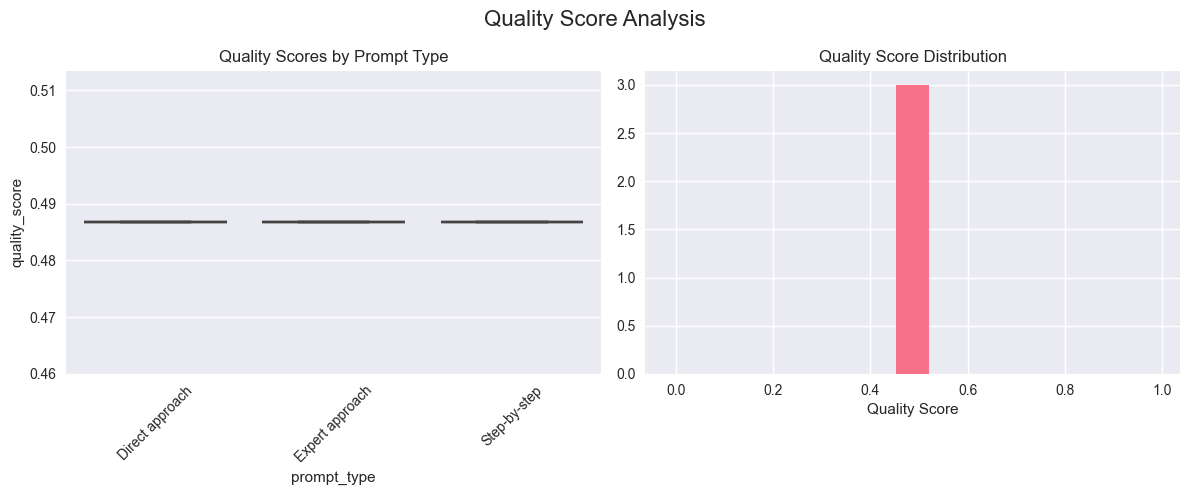


🏆 Top performing prompts:
    prompt_type  quality_score  response_length
Direct approach       0.486739               35
Expert approach       0.486739               35
   Step-by-step       0.486739               35
📊 EXPERIMENT SUMMARY
Experiment: my_custom_experiment
Total Prompts: 3
Prompt Types: Direct approach, Expert approach, Step-by-step
Avg Response Time: 3.70s
Avg Response Length: 35.0 words
Avg Quality Score: 0.487
✅ Custom experiment complete!


In [18]:
# 🧪 Custom Experiment Template
# Modify this cell to test your own prompts!

# 1. Start your experiment
playground.new_experiment("my_custom_experiment")

# 2. Define your task
my_task = "Write your task or question here"

# 3. Test different approaches
results = []

# Example: Test different instruction styles
prompts_to_test = [
    ("Direct approach", f"Please {my_task}"),
    ("Expert approach", f"As an expert in this field, {my_task}"),
    ("Step-by-step", f"Please {my_task}. Work through this step by step."),
    # Add your own prompt variations here!
]

for prompt_name, prompt_text in prompts_to_test:
    print(f"Testing: {prompt_name}")
    result = playground.quick_test(prompt_text, prompt_type=prompt_name)
    results.append(result)
    print("-" * 50)

# 4. Analyze results
playground.evaluate_responses()
playground.show_summary()

print("✅ Custom experiment complete!")

In [19]:
# 🎮 Experiment Sandbox
# Use this space for quick tests and iterations

# Quick single prompt test
# playground.quick_test("Your prompt here")

# Quick comparison
# playground.compare_prompt_types("Your task here")

# Custom A/B test
# optimizer.a_b_test("Prompt A", "Prompt B", "Your task")

print("🎪 Sandbox ready for experiments!")

🎪 Sandbox ready for experiments!


## 🎉 Conclusion

You now have a comprehensive prompt engineering playground! This notebook provides:

### 🛠️ Core Features
- **Multiple prompting strategies** (zero-shot, few-shot, chain-of-thought)
- **Quality evaluation metrics** for objective comparison
- **A/B testing framework** for statistical validation
- **Interactive visualizations** for data analysis
- **Temperature and consistency experiments**
- **Automated prompt optimization**

### 📊 Key Learnings
- Different prompt types excel in different scenarios
- Chain-of-thought improves reasoning tasks
- Temperature affects response consistency
- Few-shot examples guide model behavior
- Quality metrics help objective evaluation

### 🚀 Next Steps
1. **Experiment with domain-specific prompts** for your use case
2. **Build a larger evaluation dataset** for more robust testing
3. **Integrate with production systems** using the patterns learned
4. **Explore advanced techniques** like prompt chaining and retrieval-augmented generation
5. **Share findings** with your team using the export functionality

### 📚 Additional Resources
- [OpenAI Prompt Engineering Guide](https://platform.openai.com/docs/guides/prompt-engineering)
- [Anthropic Prompt Library](https://docs.anthropic.com/claude/prompt-library)
- [LangChain Documentation](https://python.langchain.com/docs/)

Happy prompting! 🎯